## Importing required libraries -

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split

## Importing & exploring Bank Note (i.e. bank note authentication) dataset (downloaded from UCI ML repo) -

In [3]:
df = pd.read_csv('/content/data_banknote_authentication.txt', header=None)
print(df.shape)
df.head()

(1372, 5)


,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
# Renaming column names -
df.rename(columns={0:'f1', 1:'f2', 2:'f3', 3:'f4', 4:'target'}, inplace=True)
df.head()

,f1,f2,f3,f4,target
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [5]:
# Checking datatypes and missing values -
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      1372 non-null   float64
 1   f2      1372 non-null   float64
 2   f3      1372 non-null   float64
 3   f4      1372 non-null   float64
 4   target  1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB
None
f1        0
f2        0
f3        0
f4        0
target    0
dtype: int64


### There are no missing values and the datatypes are appropriate

In [6]:
# Visualizing target distribution -
round(df.target.value_counts(normalize=True).sort_index(ascending=True)*100, 2)

0    55.54
1    44.46
Name: target, dtype: float64

### From the above we can see the slight imbalance in the target distribution which will be taken care further by using the right metrics and performing K Fold Stratified Cross Validation

## Dividing the dataset into k folds (k=5) -

In [7]:
df['kfold'] = -1
df = df.sample(frac=1, random_state=100).reset_index(drop=True)
skf = StratifiedKFold(n_splits=5)

# Filling the new kfold column -
for f, (t_, v_) in enumerate(skf.split(X=df, y=df.target)):
    df.loc[v_, 'kfold'] = f

In [8]:
# Checking the no. of samples in each fold -
df.kfold.value_counts()

0    275
1    275
2    274
3    274
4    274
Name: kfold, dtype: int64

## Defining some helper functions to build and train the Artificial Neural Network (ANN) -

### Given: To create an ANN with 1 hidden layer and 1 output layer.
### The activation function of the hidden layer is represented by the general form: g(x) = k0 + k1 * x, and its parameters are learnable. Activation function of the output layer will be sigmoid since its a binary classification problem.

In [9]:
# Defining the no. of layers -
def layer_size(hid_nodes=8):
    n_x = 4 # no. of input layer neurons = no. of features of the dataset
    n_h1 = hid_nodes # no. of hidden layer neurons will be the no. that gives the best performance i.e. best value of metrics and least overfitting
    n_op = 1 # no. of output layer neurons = 1, since binary classification problem
    return (n_x, n_h1, n_op)

In [10]:
# No. of hidden + output layers -
n_layers = 2

In [11]:
# Initializing the weights and biases -
def init_params(*args):
    np.random.seed(1)
    model_params = dict()
    for i in range(1, len(args)):
        model_params[f'W{i}'] = np.random.randn(args[i], args[i - 1]) * 0.01
        model_params[f'b{i}'] = np.zeros((args[i], 1))
    model_params[f'K'] = np.random.randn(2) # since according to given assignment, there are 2 parameters: k0 and k1
    return model_params

In [12]:
# Defining the sigmoid function -
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

In [13]:
# Defining adaptable activation function (for the 1st hidden layer) and its derivative -
def ada_act(k0, k1, z):
  return k0 + (k1 * z) # as per the provided assignment

# dK1 (naming convention as per assignment provided) array below will have 2 elements since there are 2 learnable parameters in the ada_act above
def d_ada_act(da1, z1):
  return np.array([np.mean(da1.flatten()), np.mean(np.multiply(da1, z1).flatten())])

In [14]:
# Forward propagation -
def fwd_prop(X, model_params):
    catch = dict() # to store computed zi, ai values
    for i in range(n_layers):
        if i == 0:
            catch[f'Z{i + 1}'] = np.matmul(model_params[f'W{i + 1}'], X) + model_params[f'b{i + 1}']
        else:
            catch[f'Z{i + 1}'] = np.matmul(model_params[f'W{i + 1}'], catch[f'a{i}']) + model_params[f'b{i + 1}']

        if i != (n_layers - 1):
            catch[f'a{i + 1}'] = ada_act(model_params[f'K'][0], model_params[f'K'][1], catch[f'Z{i + 1}'])
        else:
            catch[f'a{i + 1}'] = sigmoid(catch[f'Z{i + 1}'])

    return catch

In [15]:
# Defining the Binary Cross Entropy cost function -
def compute_cost(a2, y):
    m = y.size
    cost = -np.sum(np.multiply(y, np.log(a2)) + np.multiply((1 - y), np.log(1 - a2))) / m
    return cost

In [16]:
# Defining the function for backward propagation -
def bwd_prop(model_params, catch, X, y):
    m = y.size
    gradients = dict()
    W1, b1 = model_params['W1'], model_params['b1']
    W2, b2 = model_params['W2'], model_params['b2']
    k0, k1 = model_params['K'][0], model_params['K'][1]

    a1, a2 = catch['a1'], catch['a2']
    Z1, Z2 = catch['Z1'], catch['Z2']

    dZ2 = a2 - y
    dW2 = np.matmul(dZ2, a1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    da1 = np.matmul(W2.T, dZ2)

    dZ1 = k1 * da1 # derivative of k0 + k1*z wrt z is k1
    dW1 = np.matmul(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    dK1 = d_ada_act(da1,  Z1)

    gradients = {"dW1":dW1, "db1":db1, "dW2":dW2, "db2":db2, "dK":dK1} # dK = dK1, since only 1 hidden layer

    return gradients

In [17]:
# Updating the model parameters -
def update(model_params, gradients, lr):
    for i in range(n_layers, 0, -1):
        model_params[f'W{i}'] = model_params[f'W{i}'] - (lr * gradients[f'dW{i}'])
        model_params[f'b{i}'] = model_params[f'b{i}'] - (lr * gradients[f'db{i}'])
    model_params[f'K'] = model_params[f'K'] - (lr * gradients[f'dK'])

    return model_params

In [18]:
# Main driver function for Batch Gradient Descent -
def NN(X_train, y_train, X_test, y_test, alpha, itr, hid_nodes):
    past_cost_tr, past_cost_te = [], []
    n_x, n_h1, n_op = layer_size(hid_nodes)
    model_params = init_params(n_x, n_h1, n_op)
    print(f"Initial params: {model_params}")

    for i in range(0, itr):
        print(f"Epoch {i+1} -")
        catch = fwd_prop(X_train, model_params)
        tr_cost = compute_cost(catch['a2'], y_train)
        gradients = bwd_prop(model_params, catch, X_train, y_train)
        model_params = update(model_params, gradients, alpha)
        print(f"Updated K params after epoch {i+1}: {model_params['K']}")
        past_cost_tr.append(tr_cost)

        # Evaluating on test data after every epoch-
        catch = fwd_prop(X_test, model_params)
        te_cost = compute_cost(catch['a2'], y_test)
        print(f"Train loss: {tr_cost}, Test loss: {te_cost}")
        past_cost_te.append(te_cost)
        print("\n")

    return past_cost_tr, model_params, past_cost_te

## Performing K fold Cross Validation -

#### Rough work (shapes) -
#### num of hidden layer nodes = 8
X -> (4, 1000), w1 -> (8, 4), b1 -> (8, 1), z1/a1 -> (8, 1000)
w2 -> (1, 8), b2 -> (1, 1), z2/a2 -> (1, 1000)

In [19]:
for kfold in range(df.kfold.nunique()):
    print(f"Fold {kfold+1} -")
    train_f1s, test_f1s = [], []
    train_accs, test_accs = [], []

    X_train, y_train = df.loc[df['kfold'] != kfold, :'f4'].reset_index(drop=True), df.loc[df['kfold'] != kfold, 'target'].reset_index(drop=True)
    X_test, y_test = df.loc[df['kfold'] == kfold, :'f4'].reset_index(drop=True), df.loc[df['kfold'] == kfold, 'target'].reset_index(drop=True)
    y_train, y_test = y_train.values.reshape((1, X_train.shape[0])), y_test.values.reshape((1, X_test.shape[0]))

    # Calling the driver function -
    alpha, epochs, pred_thresh, hid_nodes = 1e-2, 750, 0.5, 8 # Defining the hyperparameters
    tr_hist, best_params, te_hist = NN(X_train.values.T, y_train, X_test.values.T, y_test, alpha, epochs, hid_nodes)

    # Printing some metrics -
    train_probs = fwd_prop(X_train.values.T, best_params)['a2']
    test_probs = fwd_prop(X_test.values.T, best_params)['a2']

    train_preds = (train_probs >= pred_thresh).astype('int').flatten()
    test_preds = (test_probs >= pred_thresh).astype('int').flatten()

    y_train, y_test = y_train.flatten(), y_test.flatten()

    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    train_accs.append(train_acc); test_accs.append(test_acc)

    train_f1 = f1_score(y_train, train_preds) # f1 score for label 1
    test_f1 = f1_score(y_test, test_preds) # f1 score for label 1
    train_f1s.append(train_f1); test_f1s.append(test_f1)

    print(f"Train accuracy: {train_acc}, Test accuracy: {test_acc}")
    print(f"Train f1: {train_f1}, Test f1: {test_f1}")
    print("\n")

# Printing the mean of the metrics across all folds -
print(f"Mean train accuracy: {np.mean(train_accs)}, Mean test accuracy: {np.mean(test_accs)}")
print(f"Mean train f1: {np.mean(train_f1s)}, Mean test f1: {np.mean(test_f1s)}")

Streaming output truncated to the last 5000 lines.
Train loss: 0.17278013307108325, Test loss: 0.18643389574057168


Epoch 507 -
Updated K params after epoch 507: [-0.18789843 -0.95539854]
Train loss: 0.17227499991121767, Test loss: 0.18594869884012416


Epoch 508 -
Updated K params after epoch 508: [-0.18788262 -0.95558278]
Train loss: 0.17177311286146063, Test loss: 0.18546660859337236


Epoch 509 -
Updated K params after epoch 509: [-0.18786686 -0.95576658]
Train loss: 0.17127444230044483, Test loss: 0.1849875961872163


Epoch 510 -
Updated K params after epoch 510: [-0.18785114 -0.95594993]
Train loss: 0.17077895891158001, Test loss: 0.1845116331087768


Epoch 511 -
Updated K params after epoch 511: [-0.18783546 -0.95613285]
Train loss: 0.17028663368038255, Test loss: 0.18403869114278298


Epoch 512 -
Updated K params after epoch 512: [-0.18781982 -0.95631533]
Train loss: 0.16979743789179666, Test loss: 0.18356874236895007


Epoch 513 -
Updated K params after epoch 513: [-0.1878042

## Final training the model now with the best hyperparameters from above -

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, :'f4'], df.loc[:, 'target'], test_size = 0.2, stratify=df.loc[:, 'target'], random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1097, 4), (1097,), (275, 4), (275,))

In [21]:
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)
y_train, y_test = y_train.values.reshape((1, X_train.shape[0])), y_test.values.reshape((1, X_test.shape[0]))

# Best hyperparameters -
alpha, epochs, pred_thresh, hid_nodes = 1e-2, 750, 0.5, 8 # Defining the hyperparameters

# Training the model -
tr_hist, best_params, te_hist = NN(X_train.values.T, y_train, X_test.values.T, y_test, alpha, epochs, hid_nodes)

# Printing the final metrics -
train_probs = fwd_prop(X_train.values.T, best_params)['a2']
test_probs = fwd_prop(X_test.values.T, best_params)['a2']

train_preds = (train_probs >= pred_thresh).astype('int').flatten()
test_preds = (test_probs >= pred_thresh).astype('int').flatten()

y_train, y_test = y_train.flatten(), y_test.flatten()

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

train_f1 = f1_score(y_train, train_preds) # f1 score for label 1
test_f1 = f1_score(y_test, test_preds) # f1 score for label 1

print(f"Train accuracy: {train_acc}, Test accuracy: {test_acc}")
print(f"Train f1: {train_f1}, Test f1: {test_f1}")

Initial params: {'W1': array([[ 0.01624345, -0.00611756, -0.00528172, -0.01072969],
       [ 0.00865408, -0.02301539,  0.01744812, -0.00761207],
       [ 0.00319039, -0.0024937 ,  0.01462108, -0.02060141],
       [-0.00322417, -0.00384054,  0.01133769, -0.01099891],
       [-0.00172428, -0.00877858,  0.00042214,  0.00582815],
       [-0.01100619,  0.01144724,  0.00901591,  0.00502494],
       [ 0.00900856, -0.00683728, -0.0012289 , -0.00935769],
       [-0.00267888,  0.00530355, -0.00691661, -0.00396754]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[-0.00687173, -0.00845206, -0.00671246, -0.00012665, -0.0111731 ,
         0.00234416,  0.01659802,  0.00742044]]), 'b2': array([[0.]]), 'K': array([-0.19183555, -0.88762896])}
Epoch 1 -
Updated K params after epoch 1: [-0.19183507 -0.88762948]
Train loss: 0.6928524343289046, Test loss: 0.6928352856625137


Epoch 2 -
Updated K params after epoch 2: [-0.1918346

## Printing some final results -

### Hence, final metrics are- Train accuracy = 0.97, Test accuracy = 0.98, Train f1 = 0.97, Test f1 = 0.97 (rounded off to 2 decimal places)

In [22]:
print(f"Final parameter values: {best_params}")

Final parameter values: {'W1': array([[ 0.10689448,  0.03742489,  0.04357396,  0.00988056],
       [-0.46380323, -0.26090419, -0.24955799, -0.11067228],
       [-0.08271358, -0.04601017, -0.03676133, -0.03911787],
       [-0.03680734, -0.01803599, -0.01368764, -0.01896291],
       [-0.37421405, -0.19593965, -0.21238063, -0.0754684 ],
       [ 0.20940998,  0.12485714,  0.12607856,  0.05263991],
       [ 0.57417769,  0.28250666,  0.30706175,  0.11286188],
       [ 0.40230901,  0.21315116,  0.21148696,  0.08354074]]), 'b1': array([[-0.02090278],
       [ 0.12946259],
       [ 0.02676033],
       [ 0.01405851],
       [ 0.10419635],
       [-0.05374983],
       [-0.1455693 ],
       [-0.10201892]]), 'W2': array([[ 0.08115792, -0.65140139, -0.14979401, -0.08747178, -0.53007166,
         0.24373754,  0.69294725,  0.47855307]]), 'b2': array([[0.22692668]]), 'K': array([-0.18551664, -0.98930944])}


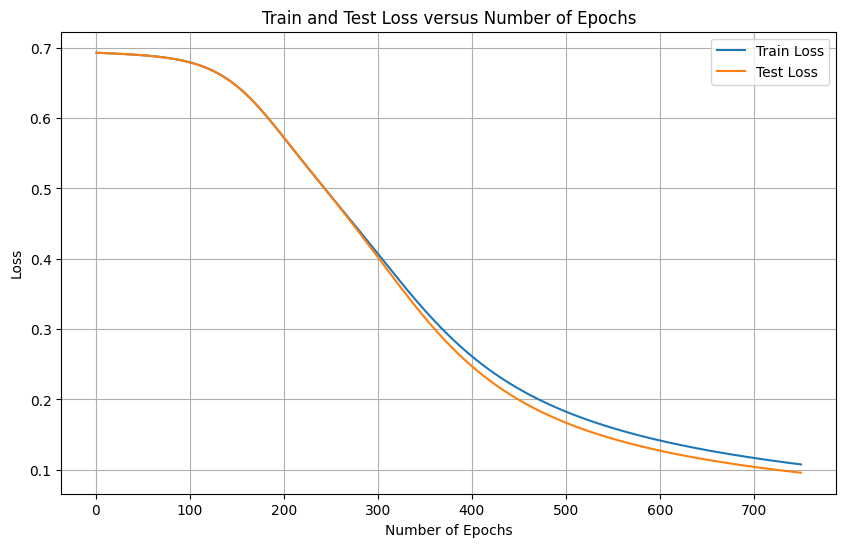

In [23]:
# Plot of train, test loss versus epochs -
epochs = list(range(1, epochs + 1))

# Plotting the train and test loss values versus the number of epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, tr_hist, label='Train Loss')
plt.plot(epochs, te_hist, label='Test Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss versus Number of Epochs')
plt.legend()
plt.grid(True)
plt.show()